In [46]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform, loguniform

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#### Importing Dataset

In [47]:
random.seed(1)

data_dir = '../data/'

df = pd.read_csv(os.path.join(data_dir, 'combined.csv'))

df.head()

,Sample_ID,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000283907,ENSG00000283913,ENSG00000284032,ENSG00000284373,ENSG00000284387,ENSG00000284395,ENSG00000284505,ENSG00000284552,Disease,characteristics_ch1_bmi
0,GSM1501013,8.002176,0.175238,4.949994,3.285351,0.959516,0.672894,59.325067,4.168056,8.104327,...,3.031789,0.903138,1.222211,0.132392,0.491394,-0.079424,-0.255411,3.071849,normal control,27.1
1,GSM1501014,23.292853,-0.031148,5.657237,2.786927,1.203578,0.358625,46.002714,4.889903,7.588060,...,1.819534,-0.021741,0.487849,-0.066907,0.195198,0.178077,-0.190626,1.399320,healthy obese,30.5
2,GSM1501015,10.557890,0.097413,7.680354,2.795125,0.789783,0.733455,43.835288,5.133417,9.559194,...,1.914932,0.424076,0.423539,-0.155705,0.086307,0.230390,-0.489850,1.632879,normal control,25.3
3,GSM1501016,10.272135,0.066298,8.835539,3.166677,0.941032,0.755181,51.390227,4.168056,10.980774,...,1.313128,0.501803,0.357365,-0.321937,0.232894,-0.066718,-0.233382,2.117271,normal control,25.8
4,GSM1501017,8.290414,-0.039647,5.792685,2.203175,0.846344,0.612263,55.423440,3.657327,10.710821,...,4.507792,0.120017,0.452607,-0.263615,0.443599,0.291308,-0.474034,3.032463,normal control,23.5


#### Encoding categorical data

In [48]:
le = LabelEncoder()

y = le.fit_transform(df['Disease'])

X = df.drop(columns = ['Sample_ID', 'Disease'])
X.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283787,ENSG00000283907,ENSG00000283913,ENSG00000284032,ENSG00000284373,ENSG00000284387,ENSG00000284395,ENSG00000284505,ENSG00000284552,characteristics_ch1_bmi
0,8.002176,0.175238,4.949994,3.285351,0.959516,0.672894,59.325067,4.168056,8.104327,3.010408,...,-0.246719,3.031789,0.903138,1.222211,0.132392,0.491394,-0.079424,-0.255411,3.071849,27.1
1,23.292853,-0.031148,5.657237,2.786927,1.203578,0.358625,46.002714,4.889903,7.588060,3.464364,...,0.040158,1.819534,-0.021741,0.487849,-0.066907,0.195198,0.178077,-0.190626,1.399320,30.5
2,10.557890,0.097413,7.680354,2.795125,0.789783,0.733455,43.835288,5.133417,9.559194,2.829070,...,-0.248596,1.914932,0.424076,0.423539,-0.155705,0.086307,0.230390,-0.489850,1.632879,25.3
3,10.272135,0.066298,8.835539,3.166677,0.941032,0.755181,51.390227,4.168056,10.980774,2.733645,...,-0.086860,1.313128,0.501803,0.357365,-0.321937,0.232894,-0.066718,-0.233382,2.117271,25.8
4,8.290414,-0.039647,5.792685,2.203175,0.846344,0.612263,55.423440,3.657327,10.710821,2.708227,...,0.337941,4.507792,0.120017,0.452607,-0.263615,0.443599,0.291308,-0.474034,3.032463,23.5


#### Train, Test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_test.shape)

(106, 21662)
(27, 21662)


## Support Vector Machine

#### Defining Pipline

In [50]:
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('classifier', SVC(class_weight='balanced')) 
]
pipeline = ImbPipeline(pipeline_steps)
print("\nDefined Pipeline:")
print(pipeline)


Defined Pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(class_weight='balanced'))])


#### Training, Optimising and Results


Starting RandomizedSearchCV on Pipeline...


c:\Users\jaydn\Documents\Projects\Human-Liver-RNA-Seq-Gene-Expression-Analysis\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 30 is smaller than n_iter=200. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV on Pipeline complete.

Best hyperparameters found for the pipeline:
{'classifier__kernel': 'linear', 'classifier__C': np.float64(0.001)}

Best cross-validation score:
0.5827665984808842

Best Pipeline Model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 SVC(C=np.float64(0.001), class_weight='balanced',
                     kernel='linear'))])

--- Evaluation of Best Tuned Pipeline on Test Set ---
Accuracy: 0.8518518518518519

Classification Report:
                precision    recall  f1-score  support
healthy obese    1.000000  1.000000  1.000000      5.0
nafld            1.000000  0.600000  0.750000      5.0
nash             0.800000  1.000000  0.888889      4.0
normal control   0.777778  0.875000  0.823529      8.0
pbc              0.500000  0.500000  0.500000      2.0
psc              1.000000  1.000000  1.000000      3.0
macro avg        0.846296  0.829167  0.827070     27.0
weighted avg     0.867490  0.851852  0.8

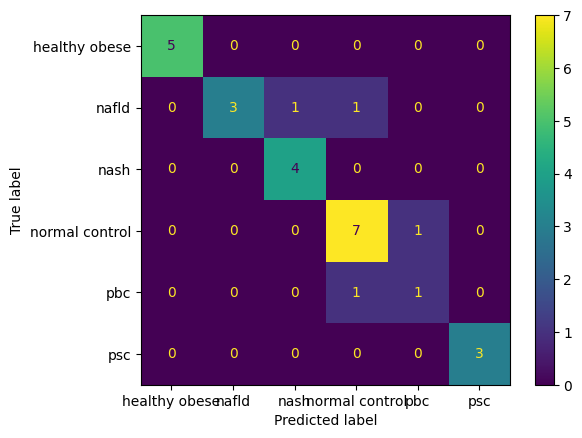

In [51]:
# good parameters:
# {'classifier__kernel': 'linear', 'classifier__C': np.float64(0.001)}

param_dist = [
    {
        'classifier__kernel': ['linear'],
        'classifier__C': np.logspace(-3, 3, 5),
    },
    
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': np.logspace(-3, 3, 5),
        'classifier__gamma': np.logspace(-3, 3, 5),
    },
]

random_search_pipeline = RandomizedSearchCV(
    estimator=pipeline,                
    param_distributions=param_dist,  
    n_iter=200,                        
    cv=5,                            
    scoring='f1_weighted',             
    verbose=0,                   
    n_jobs=-1                          
)

print("\nStarting RandomizedSearchCV on Pipeline...")
random_search_pipeline.fit(X_train, y_train)
print("RandomizedSearchCV on Pipeline complete.")

print("\nBest hyperparameters found for the pipeline:")
print(random_search_pipeline.best_params_)

print("\nBest cross-validation score:")
print(random_search_pipeline.best_score_)

best_pipeline_model = random_search_pipeline.best_estimator_
print("\nBest Pipeline Model:")
print(best_pipeline_model)

y_pred_tuned = best_pipeline_model.predict(X_test)

print("\n--- Evaluation of Best Tuned Pipeline on Test Set ---")
svm_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy: {svm_accuracy}")
print("\nClassification Report:")
svm_classfication_report = classification_report(y_test, y_pred_tuned, target_names=le.classes_, output_dict=True)
svm_classfication_report = pd.DataFrame(svm_classfication_report).transpose().drop('accuracy')
print(svm_classfication_report)

best_scaler = best_pipeline_model.named_steps['scaler']
best_classifier = best_pipeline_model.named_steps['classifier']

svm_conf_matrix = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix,
                              display_labels=le.classes_)
disp.plot()
plt.show()


#### Feature Importance


--- Top 20 Most Relevant Features ---
               feature  importance
13771  ENSG00000178342    0.001356
5270   ENSG00000124134    0.001351
2972   ENSG00000105278    0.001347
1652   ENSG00000086506    0.001315
15932  ENSG00000196126    0.001313
14093  ENSG00000180259    0.001256
7333   ENSG00000138136    0.001251
4609   ENSG00000118017    0.001251
18950  ENSG00000222047    0.001249
15290  ENSG00000186306    0.001235
9645   ENSG00000156886    0.001233
7779   ENSG00000141255    0.001231
12284  ENSG00000170484    0.001229
6665   ENSG00000134551    0.001219
20505  ENSG00000251870    0.001199
5803   ENSG00000128310    0.001195
19837  ENSG00000237048    0.001189
15944  ENSG00000196166    0.001184
1226   ENSG00000074211    0.001182
15500  ENSG00000187475    0.001182


<Axes: xlabel='importance', ylabel='feature'>

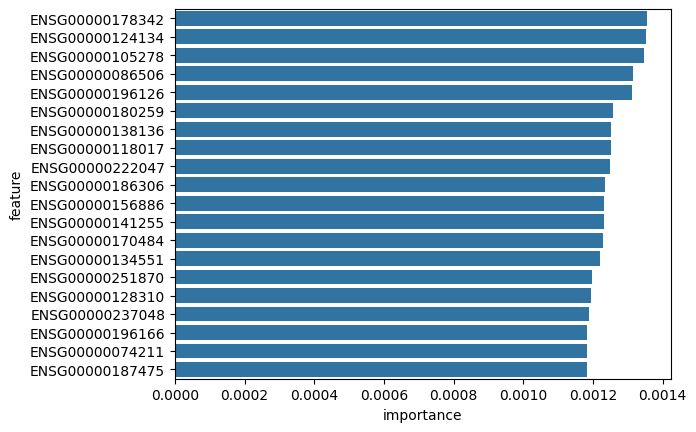

In [52]:
importances = np.abs(best_classifier.coef_[0])

feature_names = X_train.columns.tolist()

svm_feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

svm_feature_importance_df = svm_feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Top 20 Most Relevant Features ---")
print(svm_feature_importance_df.head(20))

sns.barplot(x='importance', y='feature', data=svm_feature_importance_df.head(20))

## Gradient Boosted Decision Tree

#### Defining Pipline

In [53]:
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('classifier', XGBClassifier(device='cuda', enable_categorical=False))
]
pipeline = ImbPipeline(pipeline_steps)
print("\nDefined Pipeline:")
print(pipeline)


Defined Pipeline:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=

#### Training, Optimising and Results

In [54]:
# good parametersL
# {'classifier__class_weight': None, 'classifier__colsample_bytree': np.float64(0.8982714934301164), 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': np.float64(2.934123021513229e-08), 'classifier__learning_rate': np.float64(0.03625617634576228), 'classifier__max_depth': 1, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 221, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': np.float64(1.7699302940633323e-08), 'classifier__reg_lambda': np.float64(2.9152036385288267e-09), 'classifier__subsample': np.float64(0.9464704583099741), 'classifier__use_label_encoder': False}


param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': loguniform(0.001, 0.1),
    'classifier__max_depth': randint(1, 4),
    
    'classifier__colsample_bytree': uniform(0.5, 0.5), 
    
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__gamma': loguniform(1e-9, 1e-1),
    'classifier__min_child_weight': randint(1, 5),
    'classifier__reg_alpha': loguniform(1e-9, 1e-1),
    'classifier__reg_lambda': loguniform(1e-9, 1e-1),

    'classifier__objective': ['multi:softmax'],
    'classifier__eval_metric': ['mlogloss'],
    'classifier__use_label_encoder': [False],
    'classifier__class_weight': [None, 'balanced']
}

# Initialize RandomizedSearchCV
random_search_pipeline = RandomizedSearchCV(
    estimator=pipeline,                
    param_distributions=param_dist,  
    n_iter=10,                   
    cv=5,                         
    scoring='f1_weighted',         
    verbose=0,                   
    n_jobs=8                          
)

print("\nStarting RandomizedSearchCV on Pipeline...")
random_search_pipeline.fit(X_train, y_train)
print("RandomizedSearchCV on Pipeline complete.")

print("\nBest hyperparameters found for the pipeline:")
print(random_search_pipeline.best_params_)

print("\nBest cross-validation score:")
print(random_search_pipeline.best_score_)

best_pipeline_model = random_search_pipeline.best_estimator_
print("\nBest Pipeline Model:")
print(best_pipeline_model)

y_pred_tuned = best_pipeline_model.predict(X_test)

print("\n--- Evaluation of Best Tuned Pipeline on Test Set ---")
xgb_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy: {xgb_accuracy}")

# print("\nClassification Report:")
xgb_classification_report = classification_report(y_test, y_pred_tuned, target_names=le.classes_, output_dict=True)
xgb_classification_report = pd.DataFrame(xgb_classification_report).transpose().drop('accuracy')
# print(xgb_classification_report)

best_scaler = best_pipeline_model.named_steps['scaler']
best_classifier = best_pipeline_model.named_steps['classifier']

xgb_conf_matrix = confusion_matrix(y_test, y_pred_tuned)
# print("\nConfusion Matrix:")
# disp = ConfusionMatrixDisplay(confusion_matrix=xgb_conf_matrix,
#                               display_labels=le.classes_)
# disp.plot()
# plt.show()


Starting RandomizedSearchCV on Pipeline...


c:\Users\jaydn\Documents\Projects\Human-Liver-RNA-Seq-Gene-Expression-Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:23:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV on Pipeline complete.

Best hyperparameters found for the pipeline:
{'classifier__class_weight': 'balanced', 'classifier__colsample_bytree': np.float64(0.9022462070024752), 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': np.float64(5.087321983937363e-09), 'classifier__learning_rate': np.float64(0.031626866760233636), 'classifier__max_depth': 3, 'classifier__min_child_weight': 4, 'classifier__n_estimators': 213, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': np.float64(4.432022773135392e-09), 'classifier__reg_lambda': np.float64(5.64322565290667e-08), 'classifier__subsample': np.float64(0.6859449305816773), 'classifier__use_label_encoder': False}

Best cross-validation score:
0.6171192299763728

Best Pipeline Model:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight='bala

#### Feature Importance


--- Top 20 Most Relevant Features ---
               feature  importance
9041   ENSG00000151418    0.015197
1376   ENSG00000078081    0.013863
1507   ENSG00000081791    0.013442
9619   ENSG00000156599    0.012645
10736  ENSG00000163958    0.012165
6607   ENSG00000134248    0.011345
1906   ENSG00000092096    0.011180
13531  ENSG00000176953    0.010618
8208   ENSG00000144152    0.008947
4831   ENSG00000120054    0.008448
4175   ENSG00000114767    0.008274
11388  ENSG00000166473    0.007466
8935   ENSG00000150281    0.007464
3178   ENSG00000106330    0.007407
11312  ENSG00000166183    0.007270
11602  ENSG00000167470    0.007017
7566   ENSG00000139641    0.006828
18143  ENSG00000206907    0.006767
16752  ENSG00000198910    0.006689
17500  ENSG00000202341    0.006479


<Axes: xlabel='importance', ylabel='feature'>

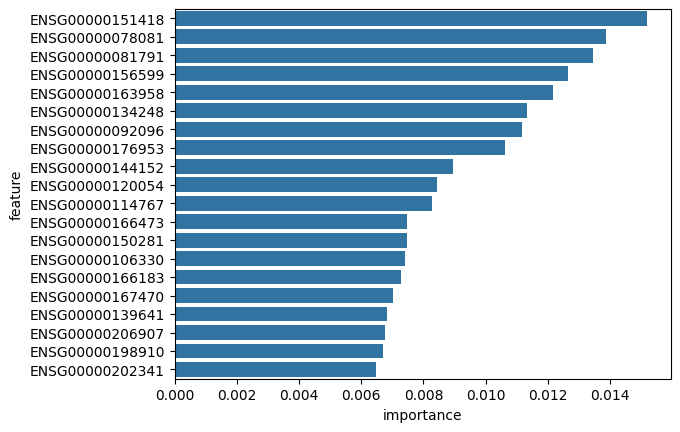

In [55]:
best_classifier = best_pipeline_model.named_steps['classifier']
importances = best_classifier.feature_importances_

feature_names = X_train.columns.tolist()

xgb_feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Top 20 Most Relevant Features ---")
print(xgb_feature_importance_df.head(20))

sns.barplot(x='importance', y='feature', data=xgb_feature_importance_df.head(20))

## Random Forest

#### Defining Pipline

In [56]:
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier())
]
pipeline = ImbPipeline(pipeline_steps)
print("\nDefined Pipeline:")
print(pipeline)


Defined Pipeline:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('classifier', RandomForestClassifier())])


#### Training, Optimising and Results

In [57]:
# good parameters:
# {'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 0.1, 'classifier__max_depth': None, 'classifier__bootstrap': True}

param_dist = {

    'classifier__n_estimators': [100, 250, 500, 1000],

    'classifier__max_features': ['sqrt', 'log2', 0.05, 0.1], 
    
    'classifier__max_depth': [3, 5, 10, 15, 20, None],

    'classifier__min_samples_split': [2, 5, 10, 20],

    'classifier__min_samples_leaf': [1, 2, 5, 10],

    'classifier__bootstrap': [True] 
}
  
random_search_pipeline = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_dist,
    scoring='f1_weighted',  
    n_iter=100, 
    cv=5, 
    verbose=0, 
    random_state=42, 
    n_jobs=-1)

print("\nStarting RandomizedSearchCV on Pipeline...")
random_search_pipeline.fit(X_train, y_train)
print("RandomizedSearchCV on Pipeline complete.")

print("\nBest hyperparameters found for the pipeline:")
print(random_search_pipeline.best_params_)

print("\nBest cross-validation score:")
print(random_search_pipeline.best_score_)

best_pipeline_model = random_search_pipeline.best_estimator_
print("\nBest Pipeline Model:")
print(best_pipeline_model)

y_pred_tuned = best_pipeline_model.predict(X_test)

print("\n--- Evaluation of Best Tuned Pipeline on Test Set ---")
random_forest_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy: {random_forest_accuracy}")
# print("\nClassification Report:")
random_forest_classification_report = classification_report(y_test, y_pred_tuned, target_names=le.classes_, output_dict=True)
random_forest_classification_report = pd.DataFrame(random_forest_classification_report).transpose().drop('accuracy')
# print(random_forest_classification_report)

best_scaler = best_pipeline_model.named_steps['scaler']
best_classifier = best_pipeline_model.named_steps['classifier']

random_forest_conf_matrix = confusion_matrix(y_test, y_pred_tuned)
# print("\nConfusion Matrix:")
# disp = ConfusionMatrixDisplay(confusion_matrix=xgb_conf_matrix,
#                               display_labels=le.classes_)
# disp.plot()
# plt.show()


Starting RandomizedSearchCV on Pipeline...
RandomizedSearchCV on Pipeline complete.

Best hyperparameters found for the pipeline:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 0.05, 'classifier__max_depth': 3, 'classifier__bootstrap': True}

Best cross-validation score:
0.6455239469525184

Best Pipeline Model:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=0.05,
                                        min_samples_leaf=5,
                                        min_samples_split=10))])

--- Evaluation of Best Tuned Pipeline on Test Set ---
Accuracy: 0.8518518518518519


#### Feature Importance


--- Top 20 Most Relevant Features ---
                       feature  importance
21661  characteristics_ch1_bmi    0.022893
7812           ENSG00000141448    0.017804
16715          ENSG00000198839    0.017738
16578          ENSG00000198464    0.016910
15949          ENSG00000196177    0.015335
17593          ENSG00000203875    0.015166
9619           ENSG00000156599    0.011065
12558          ENSG00000171723    0.010503
10876          ENSG00000164342    0.010119
8064           ENSG00000143368    0.009469
8747           ENSG00000148426    0.009449
15269          ENSG00000186198    0.008385
97             ENSG00000005469    0.008203
3679           ENSG00000110768    0.008164
4919           ENSG00000120738    0.008143
15726          ENSG00000188582    0.008012
2573           ENSG00000102245    0.007556
8977           ENSG00000150776    0.007470
747            ENSG00000056972    0.007407
11394          ENSG00000166484    0.007356


<Axes: xlabel='importance', ylabel='feature'>

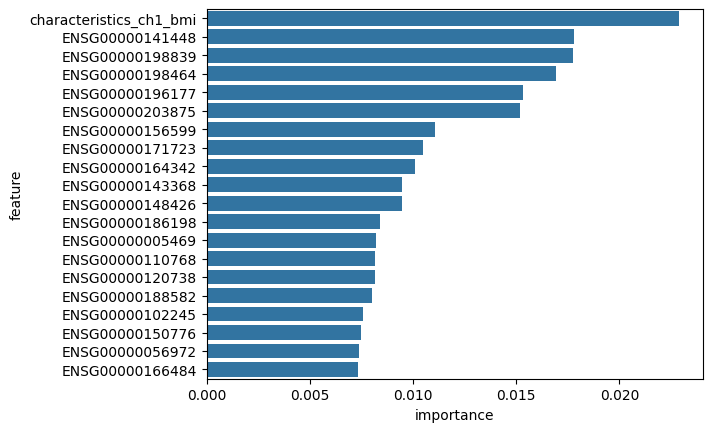

In [58]:
best_classifier = best_pipeline_model.named_steps['classifier']
importances = best_classifier.feature_importances_

feature_names = X_train.columns.tolist()

random_forest_feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

random_forest_feature_importance_df = random_forest_feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Top 20 Most Relevant Features ---")
print(random_forest_feature_importance_df.head(20))

sns.barplot(x='importance', y='feature', data=random_forest_feature_importance_df.head(20))

## Evaluation

#### Comparison of Accuracy

<BarContainer object of 3 artists>

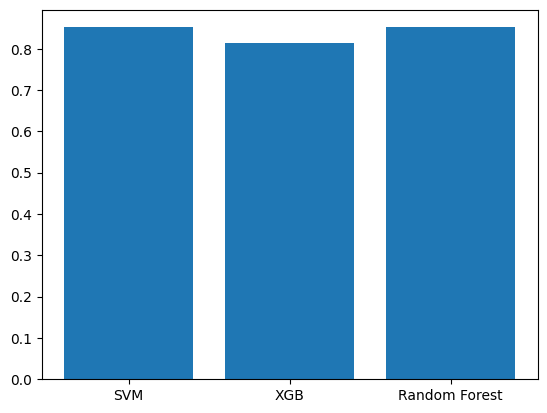

In [59]:
x = ["SVM", "XGB", "Random Forest"]
y = [svm_accuracy, xgb_accuracy, random_forest_accuracy]

plt.bar(x,y)


#### Comparison of Confusion Matrices

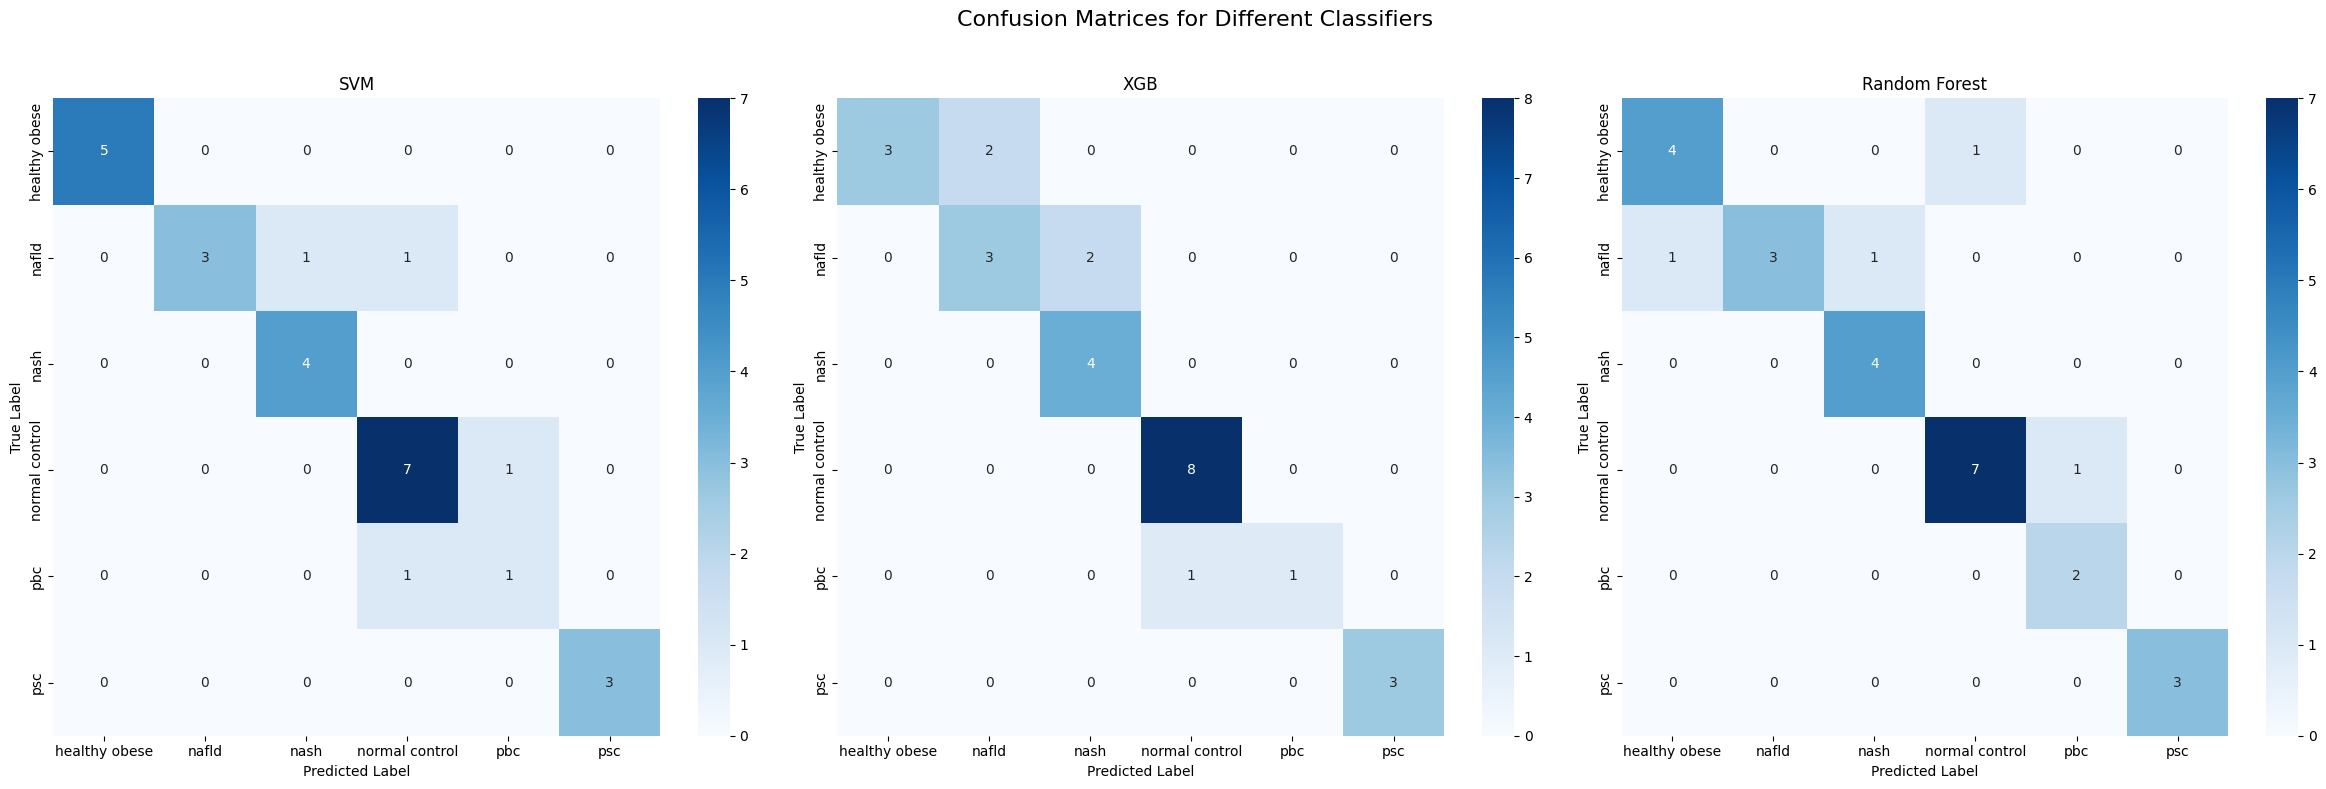

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

matrices = [svm_conf_matrix, xgb_conf_matrix, random_forest_conf_matrix]
titles = ['SVM', 'XGB', 'Random Forest']

# Plot each confusion matrix
for i, (matrix, title) in enumerate(zip(matrices, titles)):
    sns.heatmap(matrix, 
                ax=axes[i], 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                xticklabels=le.classes_, 
                yticklabels=le.classes_)
    axes[i].set_title(title)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

fig.suptitle('Confusion Matrices for Different Classifiers', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### Comparision of Important Features

In [61]:
frames = [svm_feature_importance_df.head(20), xgb_feature_importance_df.head(20), random_forest_feature_importance_df.head(20)]

combined_frames = pd.concat(frames)

combined_frames = combined_frames.drop(columns='importance')

values_counts = combined_frames.value_counts()

feature_counts_df = values_counts.reset_index()
feature_counts_df.columns = ['feature', 'model_count']

print("--- Features by Consensus Importance ---")
print("---------------------------------------")
print("Feature        | Appears in (Models) |")
print("---------------------------------------")
for _, row in feature_counts_df.head(20).iterrows():
    print(f"{row['feature']:<14} | {row['model_count']:<19} |")
print("---------------------------------------")

--- Features by Consensus Importance ---
---------------------------------------
Feature        | Appears in (Models) |
---------------------------------------
ENSG00000156599 | 2                   |
ENSG00000056972 | 1                   |
ENSG00000005469 | 1                   |
ENSG00000078081 | 1                   |
ENSG00000081791 | 1                   |
ENSG00000086506 | 1                   |
ENSG00000092096 | 1                   |
ENSG00000102245 | 1                   |
ENSG00000105278 | 1                   |
ENSG00000106330 | 1                   |
ENSG00000074211 | 1                   |
ENSG00000114767 | 1                   |
ENSG00000118017 | 1                   |
ENSG00000120054 | 1                   |
ENSG00000120738 | 1                   |
ENSG00000124134 | 1                   |
ENSG00000128310 | 1                   |
ENSG00000134248 | 1                   |
ENSG00000134551 | 1                   |
ENSG00000138136 | 1                   |
---------------------------------------


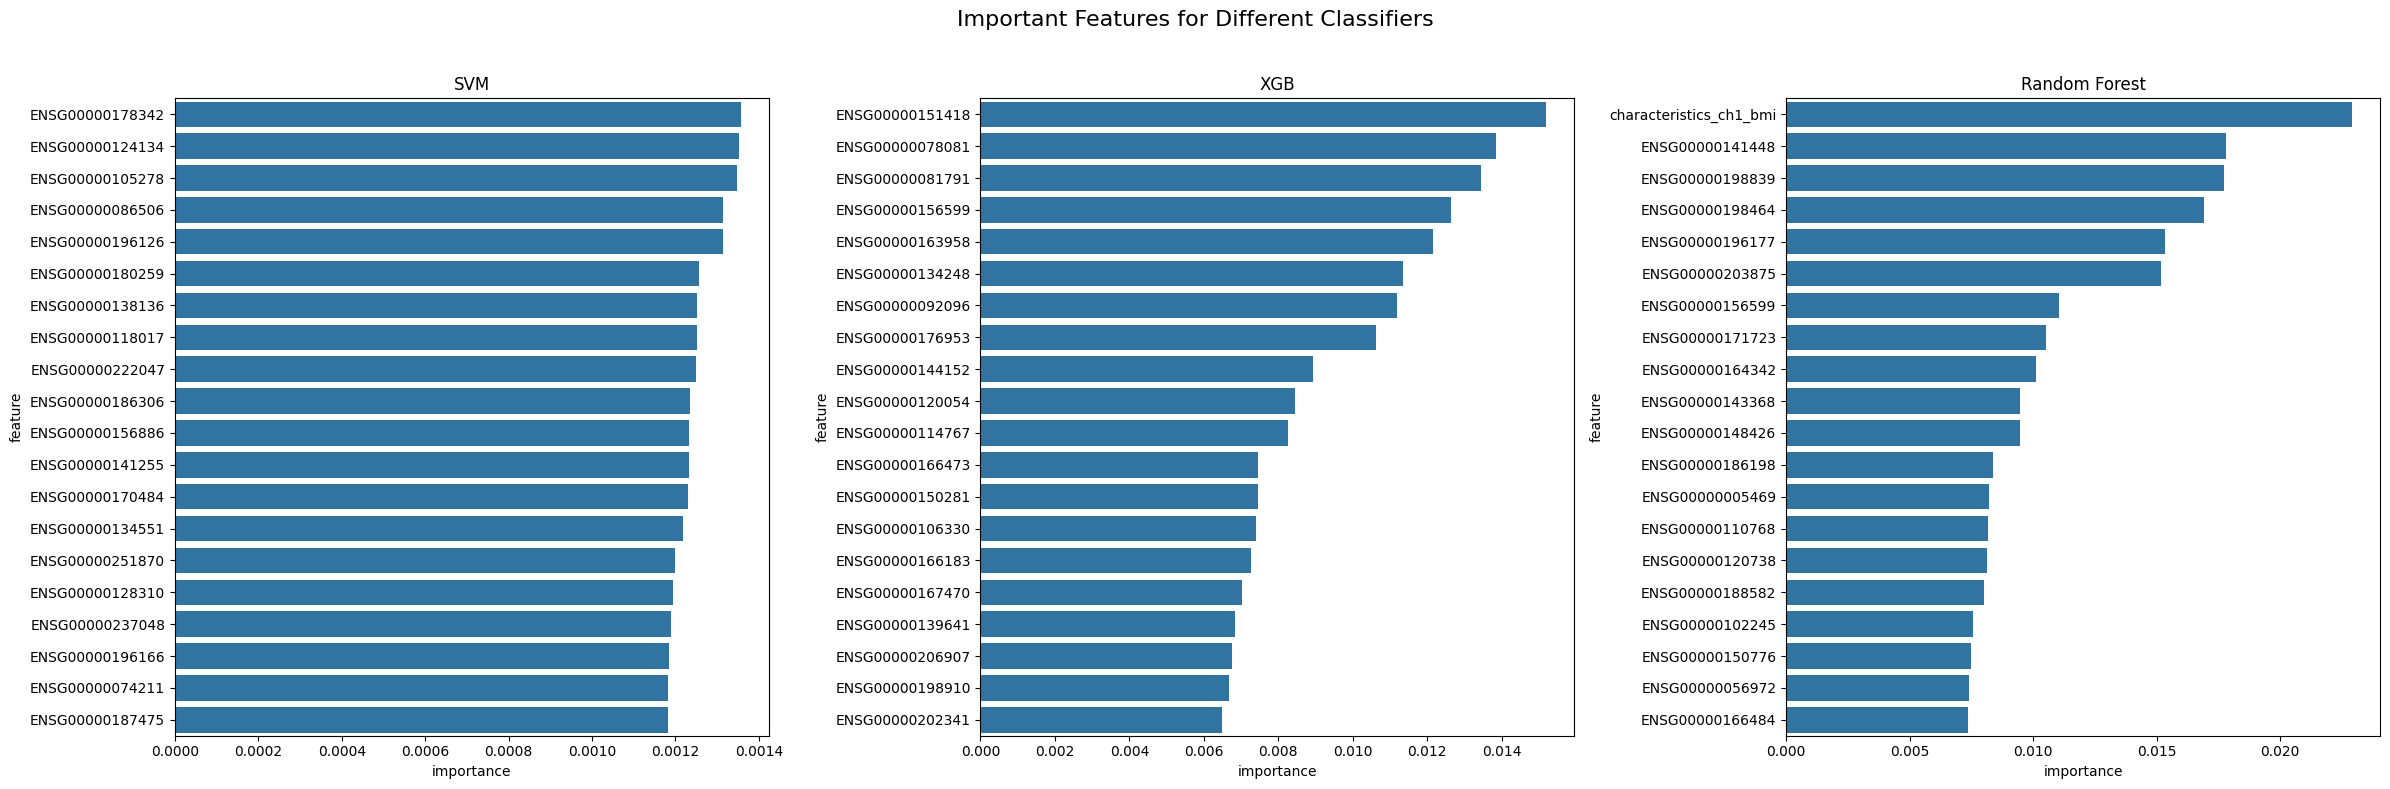

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

matrices = [svm_feature_importance_df, xgb_feature_importance_df, random_forest_feature_importance_df]
titles = ['SVM', 'XGB', 'Random Forest']

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    sns.barplot(x='importance', y='feature', data=matrix.head(20), ax=axes[i],)
    axes[i].set_title(title)

fig.suptitle('Important Features for Different Classifiers', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### Comparision of Classification Reports

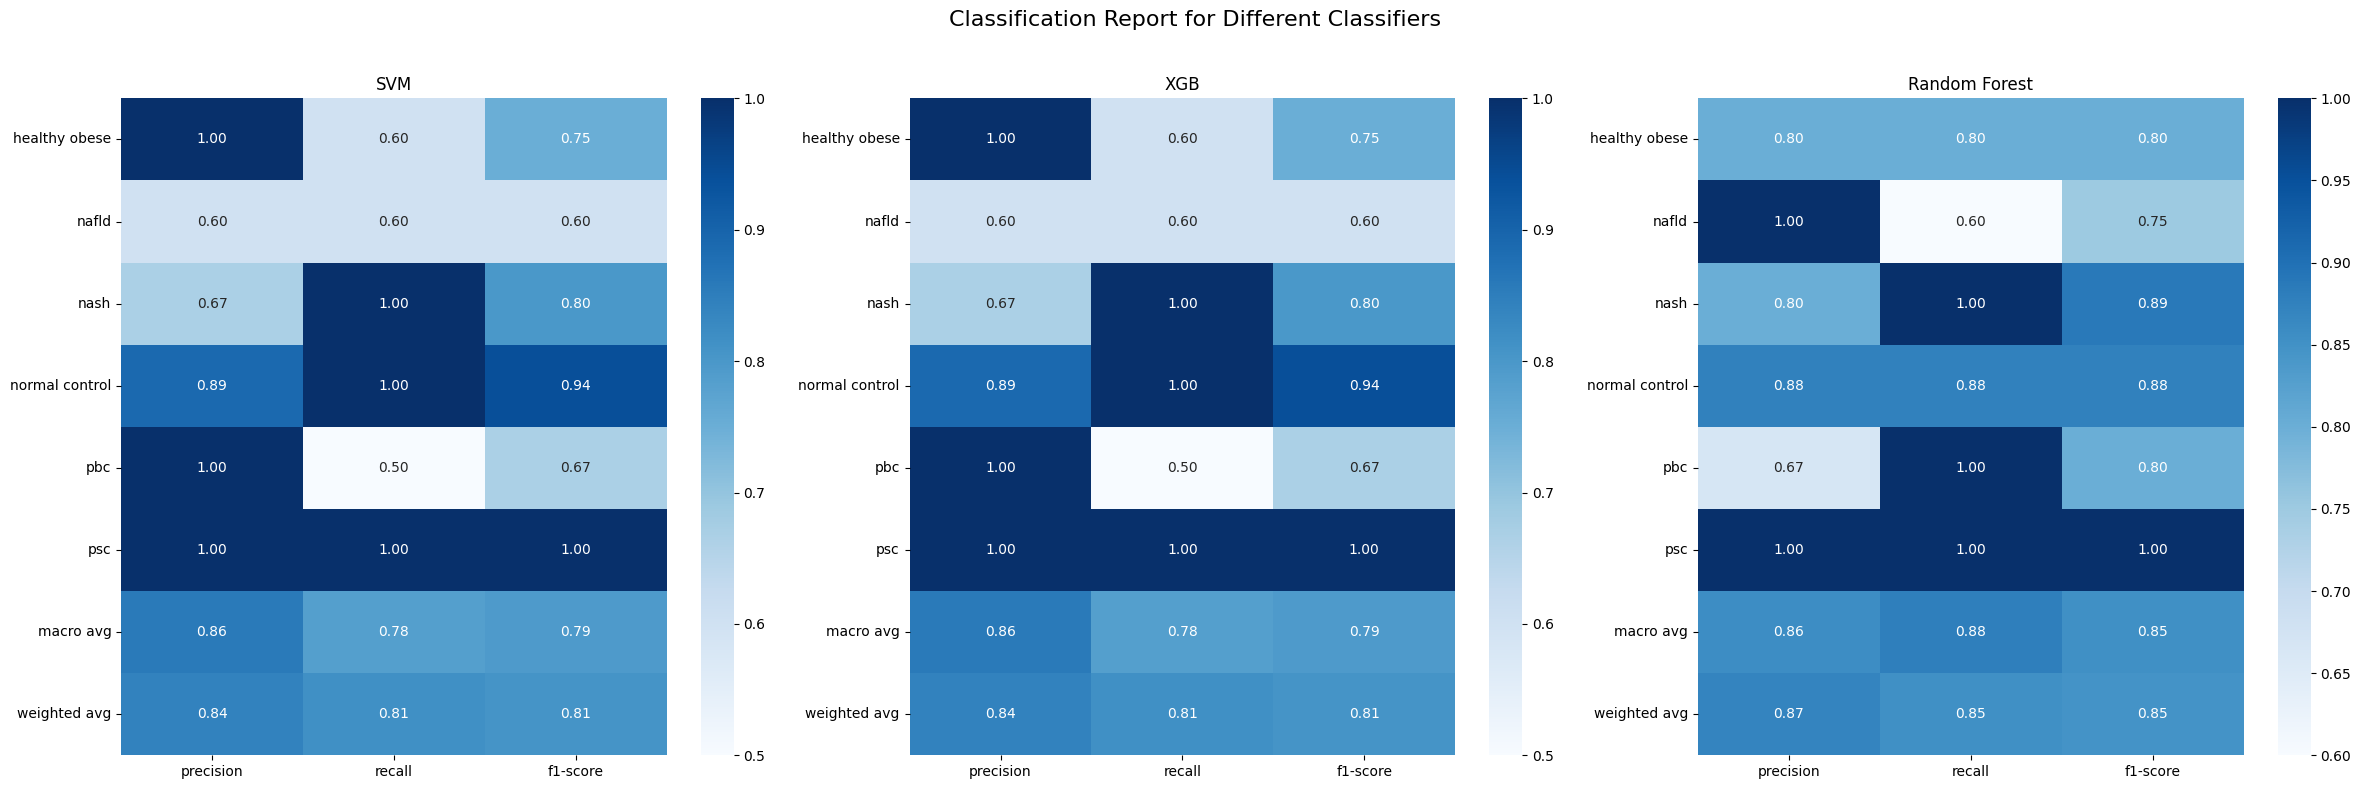

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
svm_classfication_report = svm_classfication_report.drop(columns="support", errors="ignore")
xgb_classification_report = xgb_classification_report.drop(columns="support", errors="ignore")
random_forest_classification_report = random_forest_classification_report.drop(columns="support", errors="ignore")

matrices = [svm_classfication_report, xgb_classification_report, random_forest_classification_report]
titles = ['SVM', 'XGB', 'Random Forest']

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    sns.heatmap(matrix, annot=True, fmt=".2f", ax=axes[i], cmap="Blues")
    axes[i].set_title(title)

fig.suptitle('Classification Report for Different Classifiers', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()